In [27]:
import pandas as pd
import numpy as np
from datetime import datetime

file_path = "Final Data File_Training.xlsx"

df_data_values = pd.read_excel(file_path, sheet_name='Data Set with Values', header=0)

df_data_values = df_data_values.iloc[1:].reset_index(drop=True)
dfe=df_data_values
def summarize_data(df):
    print("Initial Data Summary:")
    print(dfe.info())
    print(dfe.head())

summarize_data(dfe)

def handle_missing_values(dfe):
    for col in dfe.columns:
        if dfe[col].dtype == 'object':
            dfe[col] = dfe[col].astype('string').fillna('Unknown')  # Use Pandas 'string' dtype
        else:
            dfe[col] = dfe[col].fillna(dfe[col].median())
    return dfe


dfe = handle_missing_values(dfe)

def process_time_taken(dfe, start_col='Start Date', end_col='End Date'):
    dfe[start_col] = pd.to_datetime(dfe[start_col], errors='coerce')
    dfe[end_col] = pd.to_datetime(dfe[end_col], errors='coerce')
    dfe['time_taken'] = (dfe[end_col] - dfe[start_col]).dt.total_seconds()
    dfe = dfe.drop(columns=[start_col, end_col])
    return dfe

dfe = process_time_taken(dfe)

THRESHOLD_TIME = 10
dfe['OE_Quality_Flag'] = np.where(dfe['time_taken'] < THRESHOLD_TIME, 1, dfe['OE_Quality_Flag'])

beer_column_names = {
    "Q7. Which of the following beer types of have you consumed in the past 4 weeks?  (Beer Category )": "Domestic Light Beer",
    "Unnamed: 16": "Domestic Regular Beer",
    "Unnamed: 17": "Low Calorie Carb Beer",
    "Unnamed: 18": "Domestic Craft",
    "Unnamed: 19": "Imported Mexican Beer",
    "Unnamed: 20": "Other Imported Beer",
    "Unnamed: 21": "Non-Alcoholic Beer"
}

new_column_names = {
    "Q6 Which of the following types of alcoholic beverages have you consumed in the past 4 weeks? (Alcohol Category)": "Beer",
    "Unnamed: 8": "Flavored/Mixed Beer",
    "Unnamed: 9": "Non-Alcoholic Beers",
    "Unnamed: 10": "Hard Ciders",
    "Unnamed: 11": "Hard Kombucha",
    "Unnamed: 12": "Wine",
    "Unnamed: 13": "Hard Beverage",
    "Unnamed: 14": "Distilled Spirits"
}

dfe.rename(columns={**beer_column_names, **new_column_names}, inplace=True)

# Save preprocessed data
output_file = "Preprocessed_Data.xlsx"
dfe.to_excel(output_file, index=False)




Initial Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 36 columns):
 #   Column                                                                                                                                                                                                                                                                        Non-Null Count  Dtype         
---  ------                                                                                                                                                                                                                                                                        --------------  -----         
 0   Unique ID                                                                                                                                                                                                                                                     

In [8]:
file_path = "Preprocessed_Data.xlsx"
df = pd.read_excel(file_path)
df.rename(columns={
    "Q16A. What is the most important thing you LIKE about the shown concept}?     This can include anything you would want kept for sure or aspects that might drive you to buy or try it…       Please type a detailed response in the space below": "Q16A",
    "Q16B. What is the most important thing you DISLIKE about the shown concept}?    This can include general concerns, annoyances, or any aspects of the product that need fixed for this to be more appealing to you...     Please type a detailed response in the space below.": "Q16B",
    "Q18_1 What specific product that you are currently using would the shown product replace?\n Please type in ONE specific brand or product per space provided.": "Q18_1",
    "Q18_2 What specific product that you are currently using would the shown concept replace?\n Please type in ONE specific brand or product per space provided.": "Q18_2",
    "Q18_3 What specific product that you are currently using would the shown concept replace?\n Please type in ONE specific brand or product per space provided.": "Q18_3",
    "OE_Quality_Flag": "OE_Quality_Flag"
}, inplace=True)
print(df.columns)


Index(['Unique ID', 'Q1. What is your current age? \n(Age)',
       'Q2. What is your gender? \n(Gender)',
       'Q3. Which of the following best describes the area or community in which you live? \n(Urban/Rural)',
       'Q4.  Please indicate the answer that includes your entire household income in (previous year) before taxes. \n(Income)',
       'Q6 Which of the following types of alcoholic beverages have you consumed in the past 4 weeks?\n(Alcohol Category)',
       'Flavored/Mixed Beer', 'Non-Alcoholic Beers', 'Hard Ciders',
       'Hard Kombucha', 'Wine', 'Hard Beverage', 'Distilled Spirits',
       'Q7. Which of the following beer types of have you consumed in the past 4 weeks? \n(Beer Category )',
       'Domestic Regular Beer', 'Low Calorie Carb Beer', 'Domestic Craft',
       'Imported Mexican Beer', 'Other Imported Beer', 'Non-Alcoholic Beer',
       'Q9. How relevant would you say the shown product is to you based on what you saw and read?\n(Concept Relevance)',
       'Q1

In [9]:
print(df.columns)


Index(['Unique ID', 'Q1. What is your current age? \n(Age)',
       'Q2. What is your gender? \n(Gender)',
       'Q3. Which of the following best describes the area or community in which you live? \n(Urban/Rural)',
       'Q4.  Please indicate the answer that includes your entire household income in (previous year) before taxes. \n(Income)',
       'Q6 Which of the following types of alcoholic beverages have you consumed in the past 4 weeks?\n(Alcohol Category)',
       'Flavored/Mixed Beer', 'Non-Alcoholic Beers', 'Hard Ciders',
       'Hard Kombucha', 'Wine', 'Hard Beverage', 'Distilled Spirits',
       'Q7. Which of the following beer types of have you consumed in the past 4 weeks? \n(Beer Category )',
       'Domestic Regular Beer', 'Low Calorie Carb Beer', 'Domestic Craft',
       'Imported Mexican Beer', 'Other Imported Beer', 'Non-Alcoholic Beer',
       'Q9. How relevant would you say the shown product is to you based on what you saw and read?\n(Concept Relevance)',
       'Q1

In [12]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

file_path = "Preprocessed_Data.xlsx"
df = pd.read_excel(file_path)

df.drop(columns=["Unique ID"], inplace=True, errors="ignore")

text_columns = ["Q16A", "Q16B", "Q18_1", "Q18_2", "Q18_3"]
model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_embeddings(df, text_cols):
    for col in text_cols:
        if col in df.columns:
            df[col + "_embedding"] = df[col].fillna("").apply(lambda x: model.encode(str(x)))
    return df

df = compute_embeddings(df, text_columns)

feature_columns = [col for col in df.columns if col not in text_columns]
df_final = df[feature_columns]

output_file = "Feature_Engineered_Data.xlsx"
df_final.to_excel(output_file, index=False)

print(f"✅ Feature engineering complete. File saved to {output_file}")


✅ Feature engineering complete. File saved to Feature_Engineered_Data.xlsx


In [15]:
file_path = "Feature_Engineered_Data.xlsx"
df = pd.read_excel(file_path)
df.rename(columns={
    "Q16A. What is the most important thing you LIKE about the shown concept}?     This can include anything you would want kept for sure or aspects that might drive you to buy or try it…       Please type a detailed response in the space below": "Q16A",
    "Q16B. What is the most important thing you DISLIKE about the shown concept}?    This can include general concerns, annoyances, or any aspects of the product that need fixed for this to be more appealing to you...     Please type a detailed response in the space below.": "Q16B",
    "Q18_1 What specific product that you are currently using would the shown product replace?\n Please type in ONE specific brand or product per space provided.": "Q18_1",
    "Q18_2 What specific product that you are currently using would the shown concept replace?\n Please type in ONE specific brand or product per space provided.": "Q18_2",
    "Q18_3 What specific product that you are currently using would the shown concept replace?\n Please type in ONE specific brand or product per space provided.": "Q18_3",
    "OE_Quality_Flag": "OE_Quality_Flag"
}, inplace=True)
print(df.columns)

Index(['Q1. What is your current age? \n(Age)',
       'Q2. What is your gender? \n(Gender)',
       'Q3. Which of the following best describes the area or community in which you live? \n(Urban/Rural)',
       'Q4.  Please indicate the answer that includes your entire household income in (previous year) before taxes. \n(Income)',
       'Q6 Which of the following types of alcoholic beverages have you consumed in the past 4 weeks?\n(Alcohol Category)',
       'Flavored/Mixed Beer', 'Non-Alcoholic Beers', 'Hard Ciders',
       'Hard Kombucha', 'Wine', 'Hard Beverage', 'Distilled Spirits',
       'Q7. Which of the following beer types of have you consumed in the past 4 weeks? \n(Beer Category )',
       'Domestic Regular Beer', 'Low Calorie Carb Beer', 'Domestic Craft',
       'Imported Mexican Beer', 'Other Imported Beer', 'Non-Alcoholic Beer',
       'Q9. How relevant would you say the shown product is to you based on what you saw and read?\n(Concept Relevance)',
       'Q10. How appeal

In [16]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from textblob import TextBlob


text_columns = ["Q16A", "Q16B", "Q17. We would like to know what effect this new product might have on the other beverages you buy. If it were available, would the shown product…? \n(Concept_Replacement Product)", "Q18_1", "Q18_2", "Q18_3"]

for col in text_columns:
    if col not in df.columns:
        print(f"⚠️ Warning: Column {col} not found in dataset! Creating an empty column.")
        df[col] = ""


df[text_columns] = df[text_columns].fillna("")


model = SentenceTransformer("all-MiniLM-L6-v2")

def compute_embeddings(df, text_cols):
    for col in text_cols:
        df[col + "_embedding"] = df[col].apply(lambda x: model.encode(str(x)) if isinstance(x, str) else np.zeros(384))
    return df

df = compute_embeddings(df, text_columns)


similarity_model = pipeline("text-classification", model="sentence-transformers/paraphrase-MiniLM-L6-v2")

def detect_copy_paste(df, text_cols):
    for col in text_cols:
        df[col + "_copypaste_score"] = df[col].apply(lambda x: similarity_model(x)[0]['score'] if isinstance(x, str) else 0)
    return df

df = detect_copy_paste(df, text_columns)


def detect_ai_generated_text(text):
    if isinstance(text, str):
        sentiment = TextBlob(text).sentiment.polarity
        unusual_words = sum(1 for word in text.split() if len(word) > 10)
        return sentiment, unusual_words
    return 0, 0

df["ai_sentiment"], df["ai_unusual_words"] = zip(*df["Q16A"].apply(detect_ai_generated_text))


feature_columns = [col for col in df.columns if col not in text_columns]
df_final = df[feature_columns]

output_file = "Final_Processed_Data.xlsx"
df_final.to_excel(output_file, index=False)

print(f"✅ Feature engineering and NLP processing complete. File saved to {output_file}")


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


✅ Feature engineering and NLP processing complete. File saved to Final_Processed_Data.xlsx


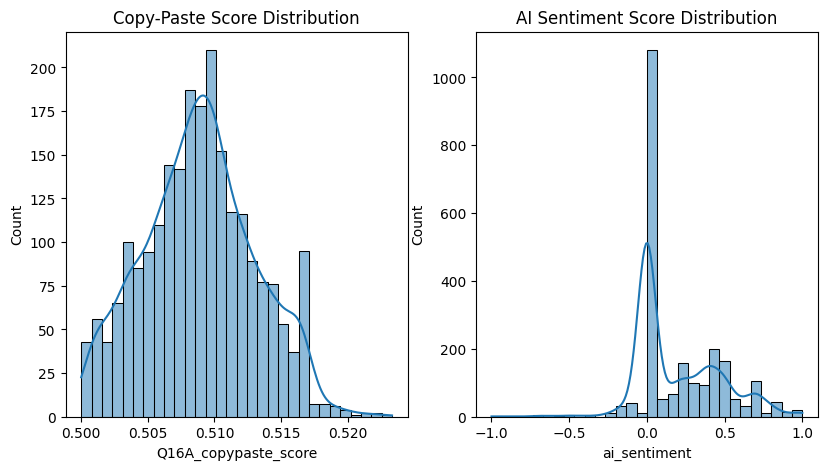

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed dataset
df = pd.read_excel("Final_Processed_Data.xlsx")

# Feature Distribution Analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['Q16A_copypaste_score'], bins=30, kde=True)
plt.title("Copy-Paste Score Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df['ai_sentiment'], bins=30, kde=True)
plt.title("AI Sentiment Score Distribution")



plt.show()
